In [ ]:
#pip install sysidentpy

In [ ]:
#pip install catboost

In [4]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data


# Generate a dataset of a simulated dynamical system
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=80)

In [5]:
from sysidentpy.polynomial_basis import PolynomialNarmax

model = PolynomialNarmax(non_degree=2,
                         order_selection=True,
                         n_info_values=10,
                         extended_least_squares=False,
                         ylag=2, xlag=2,
                         info_criteria='aic',
                         estimator='least_squares'
)
model.fit(x_train, y_train)
yhat = model.predict(x_valid, y_valid)
results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print(results)

      Regressors Parameters         ERR
0        x1(k-2)     0.9000  0.95889937
1         y(k-1)     0.2000  0.03769795
2  x1(k-1)y(k-1)     0.1000  0.00339957
3      x1(k-1)^2    -0.0003  0.00000002
4       y(k-1)^2     0.0004  0.00000003
5   y(k-2)y(k-1)    -0.0003  0.00000002
6  x1(k-1)y(k-2)     0.0002  0.00000001
7  x1(k-2)y(k-1)    -0.0002  0.00000001


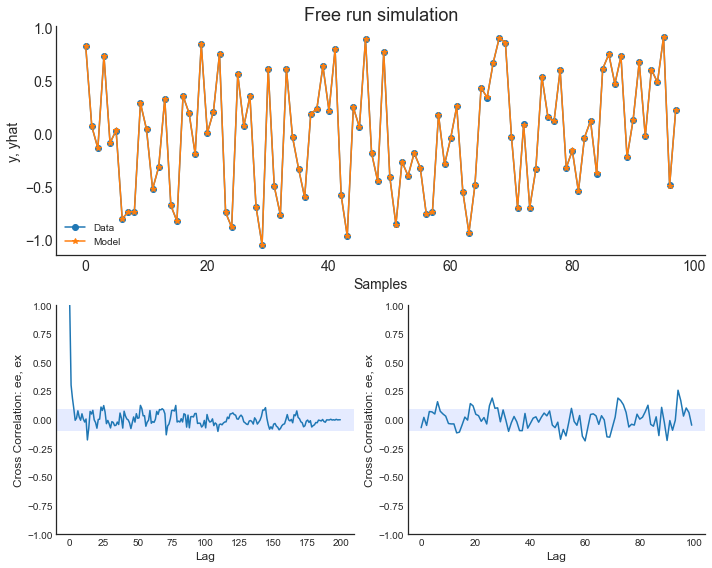

In [6]:
ee, ex, extras, lam = model.residuals(x_valid, y_valid, yhat)
model.plot_result(y_valid, yhat, ee, ex)

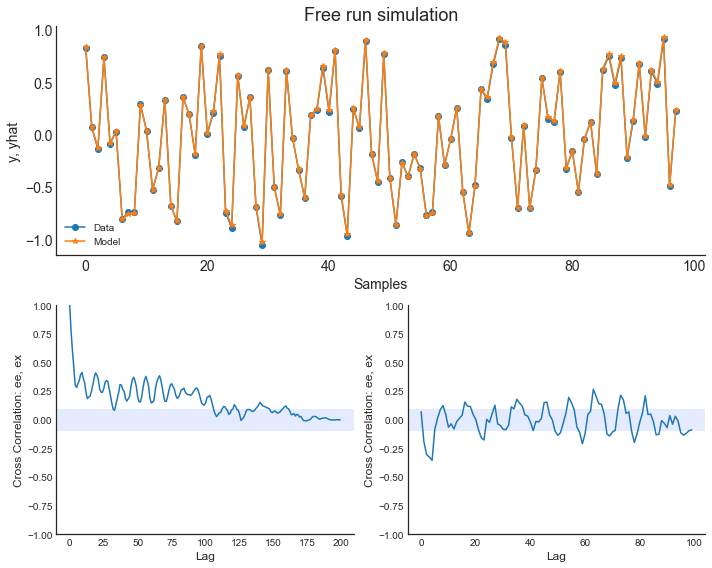

In [7]:
from sysidentpy.neural_network import NARXNN

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

narx_net = NARXNN(net=NARX(),
                  ylag=2,
                  xlag=2,
                  loss_func='mse_loss',
                  optimizer='Adam',
                  epochs=200,
                  verbose=False,
                  optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

train_dl = narx_net.data_transform(x_train, y_train)
valid_dl = narx_net.data_transform(x_valid, y_valid)
narx_net.fit(train_dl, valid_dl)
yhat = narx_net.predict(x_valid, y_valid)
ee, ex, extras, lam = narx_net.residuals(x_valid, y_valid, yhat)
narx_net.plot_result(y_valid, yhat, ee, ex)

09-18 13:12:01 - INFO - Training the model
09-18 13:12:01 - INFO - Creating the regressor matrix
09-18 13:12:01 - INFO - The regressor matrix have 5 features
09-18 13:12:02 - INFO - Done! Model is built!


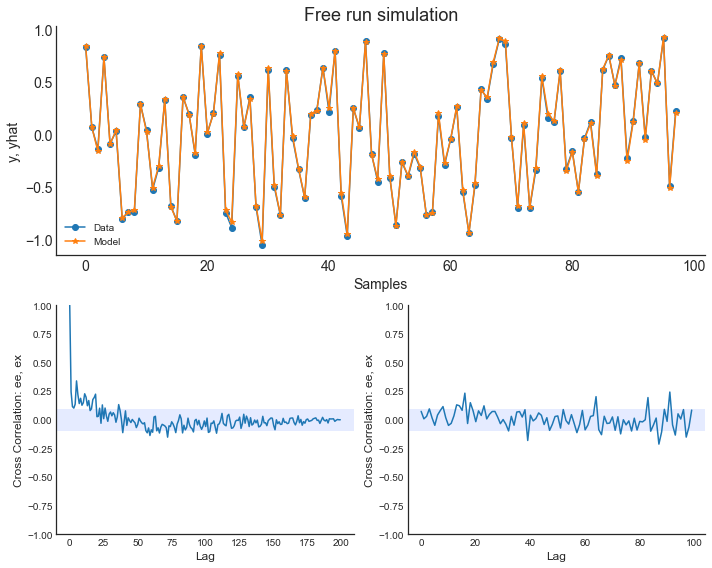

In [9]:
from sysidentpy.general_estimators import NARX
from catboost import CatBoostRegressor

catboost_narx = NARX(base_estimator=CatBoostRegressor(iterations=300,
                                                      learning_rate=0.1,
                                                      depth=6),
                     xlag=2,
                     ylag=2,
                     fit_params={'verbose': False}
)

catboost_narx.fit(x_train, y_train)
yhat = catboost_narx.predict(x_valid, y_valid)
ee, ex, extras, lam = catboost_narx.residuals(x_valid, y_valid, yhat)
catboost_narx.plot_result(y_valid, yhat, ee, ex)

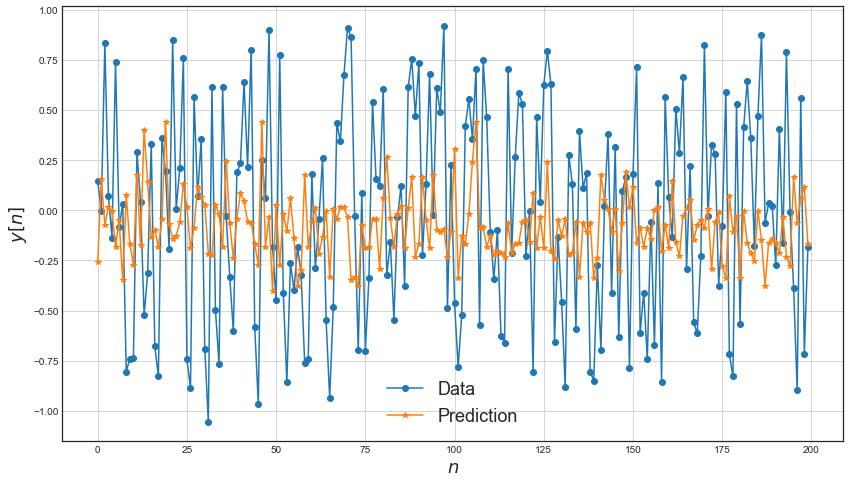

In [10]:
def plot_results(yvalid, yhat):
    _, ax = plt.subplots(figsize=(14, 8))
    ax.plot(y_valid[:200], label='Data', marker='o')
    ax.plot(yhat[:200], label='Prediction', marker='*')
    ax.set_xlabel("$n$", fontsize=18)
    ax.set_ylabel("$y[n]$", fontsize=18)
    ax.grid()
    ax.legend(fontsize=18)
    plt.show()

catboost = CatBoostRegressor(iterations=300,
                            learning_rate=0.1,
                            depth=6)
catboost.fit(x_train, y_train, verbose=False)
plot_results(y_valid, catboost.predict(x_valid))